In [1]:
%pip install -q matplotlib pandas tqdm hyperactive

Note: you may need to restart the kernel to use updated packages.


In [14]:
from basicpy import BaSiC, datasets
from matplotlib import pyplot as plt
import numpy as np
from hyperactive import Hyperactive
import pandas as pd
from tqdm import tqdm

plt.rcParams["font.family"] = ""

In [13]:
def calculate_entropy(image_float, qmin=0.01, qmax=0.99, ignore_zeros=True):
    """Calculate the entropy of an image.
    Parameters
    ----------
    image_float : array
        The image.
    vmin : float
        The minimum value of the image.
    vmax : float
        The maximum value of the image.
    Returns
    -------
    entropy : float
        The entropy of the image.
    """
    vmin, vmax = np.quantile(image_float, [qmin, qmax])
    image = (image_float - vmin) / (vmax - vmin)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    hist = np.histogram(image, bins=256, range=(0, 256))[0]
    if ignore_zeros:
        hist = hist[hist > 0]
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log(hist))
    return entropy

In [4]:
brain_wsi_image = datasets.wsi_brain()

In [5]:
brain_wsi_image.shape

(63, 128, 128)

In [6]:
flatfields_wsi = np.load("wsi_flatfields.npy")
darkfields_wsi = np.load("wsi_darkfields.npy")
conditions_df = pd.read_csv("wsi_conditions_df.csv").reset_index(drop=True)

In [7]:
def compose_image(img):
    img_composed = np.empty(
        (
            img.shape[1] * 7,
            img.shape[2] * 9,
        )
    )

    y = 0
    x = img.shape[2] * 8

    for j, im in enumerate(img):
        img_composed[y : y + img.shape[1], x : x + img.shape[2]] = im
        if (y // img.shape[2]) % 2 == 0:
            x -= img.shape[2]
            if x < 0:
                x = 0
                y += img.shape[1]
        else:
            x += img.shape[2]
            if x > img.shape[2] * 8:
                x = img.shape[2] * 8
                y += img.shape[1]
    return img_composed

In [8]:
composed_images = []
for i in range(len(flatfields_wsi)):
    flatfield = flatfields_wsi[i]
    darkfield = darkfields_wsi[i]
    basic = BaSiC()
    basic.flatfield = flatfield
    basic.darkfield = darkfield
    basic.baseline = np.ones(len(brain_wsi_image))

    transformed = basic.transform(brain_wsi_image)
    entropy = calculate_entropy(transformed)
    conditions_df.loc[i, "entropy"] = entropy
    composed_images.append(compose_image(transformed))

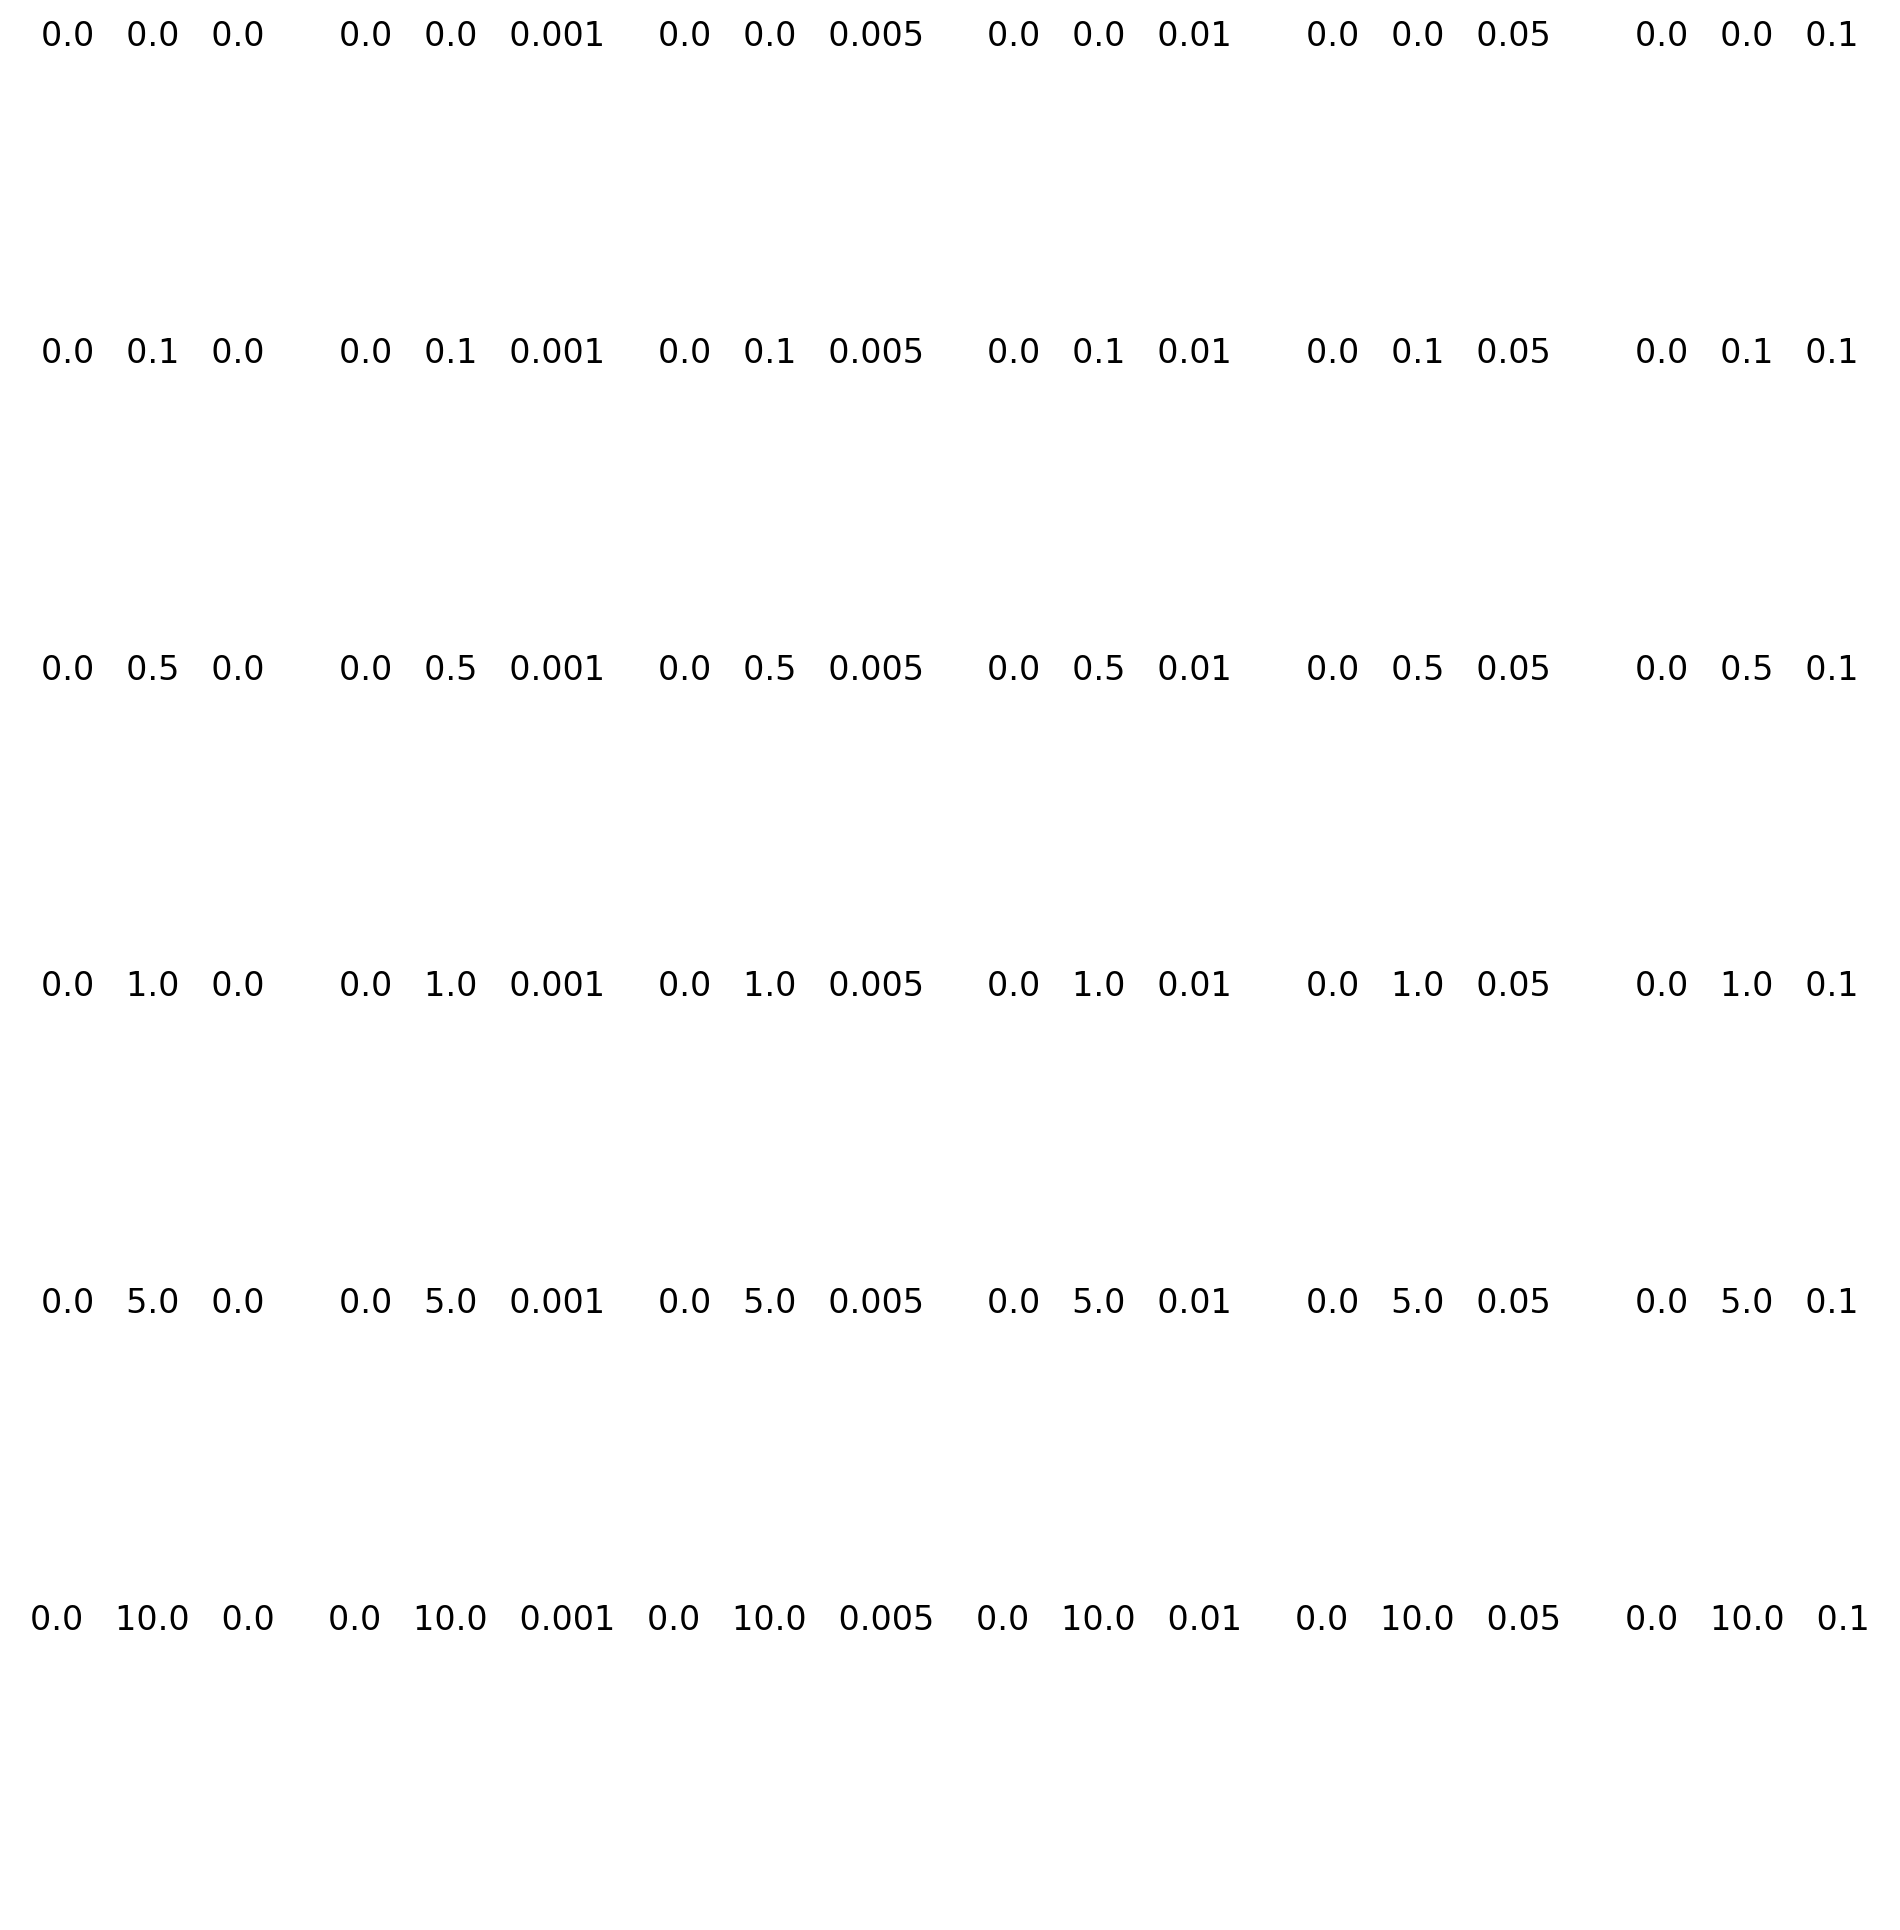

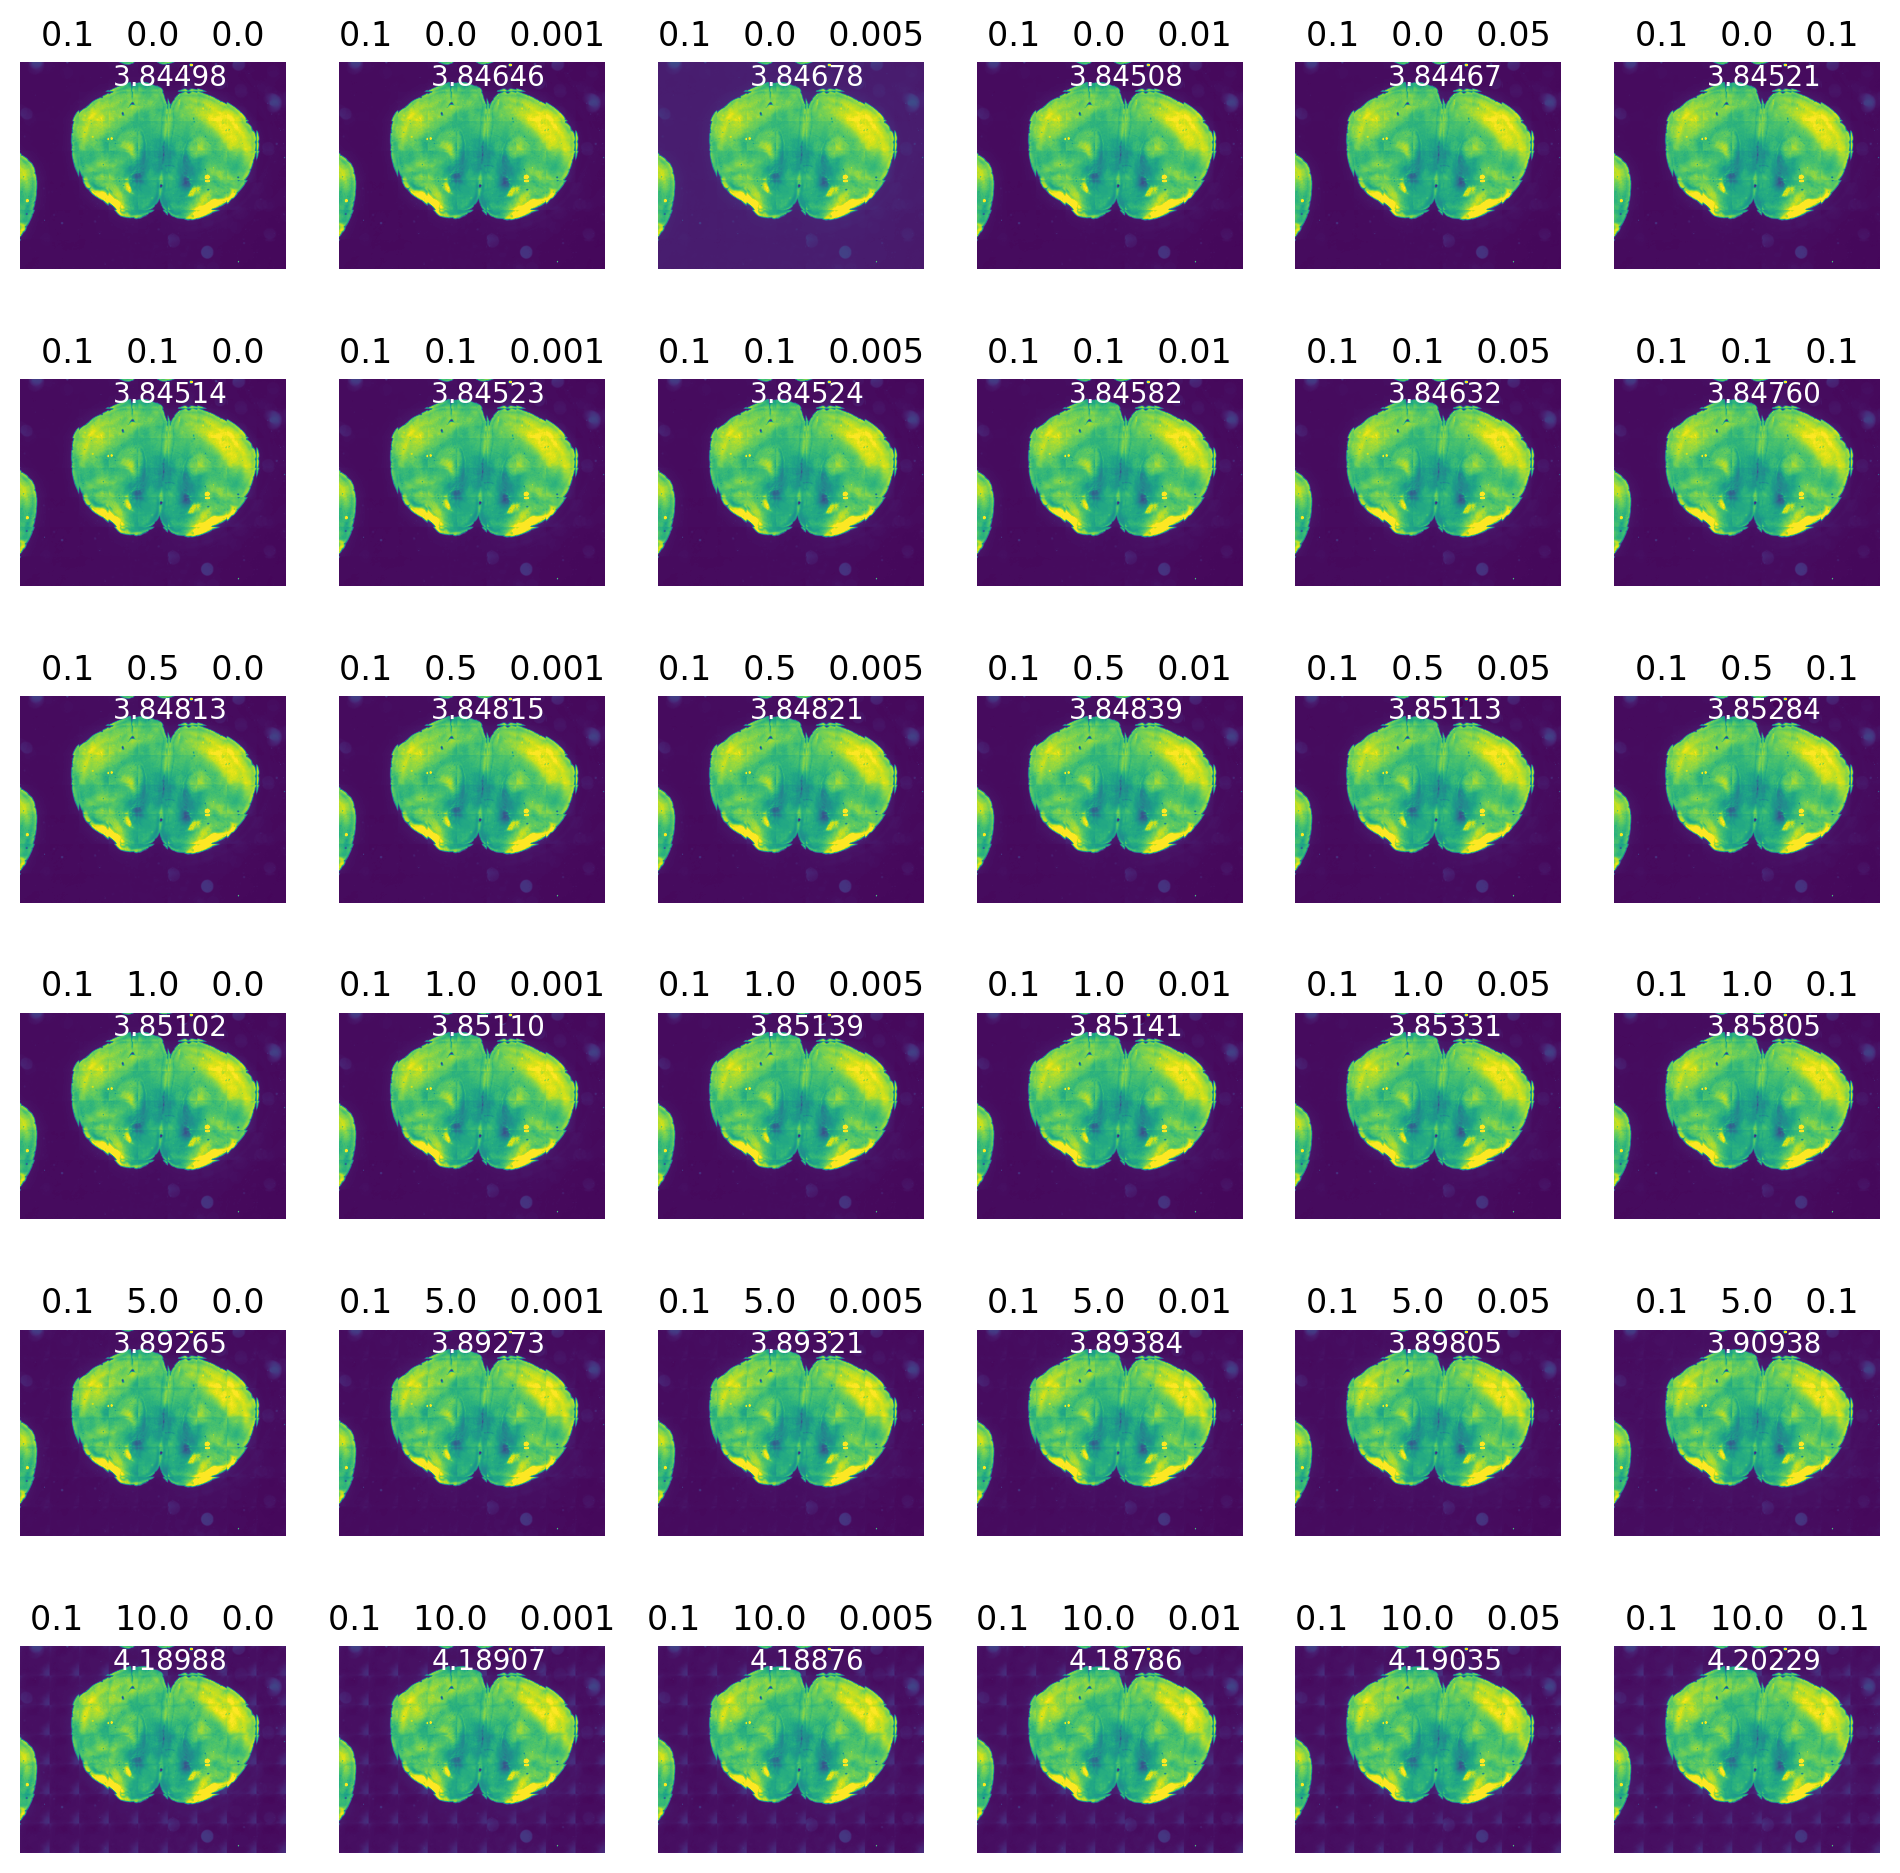

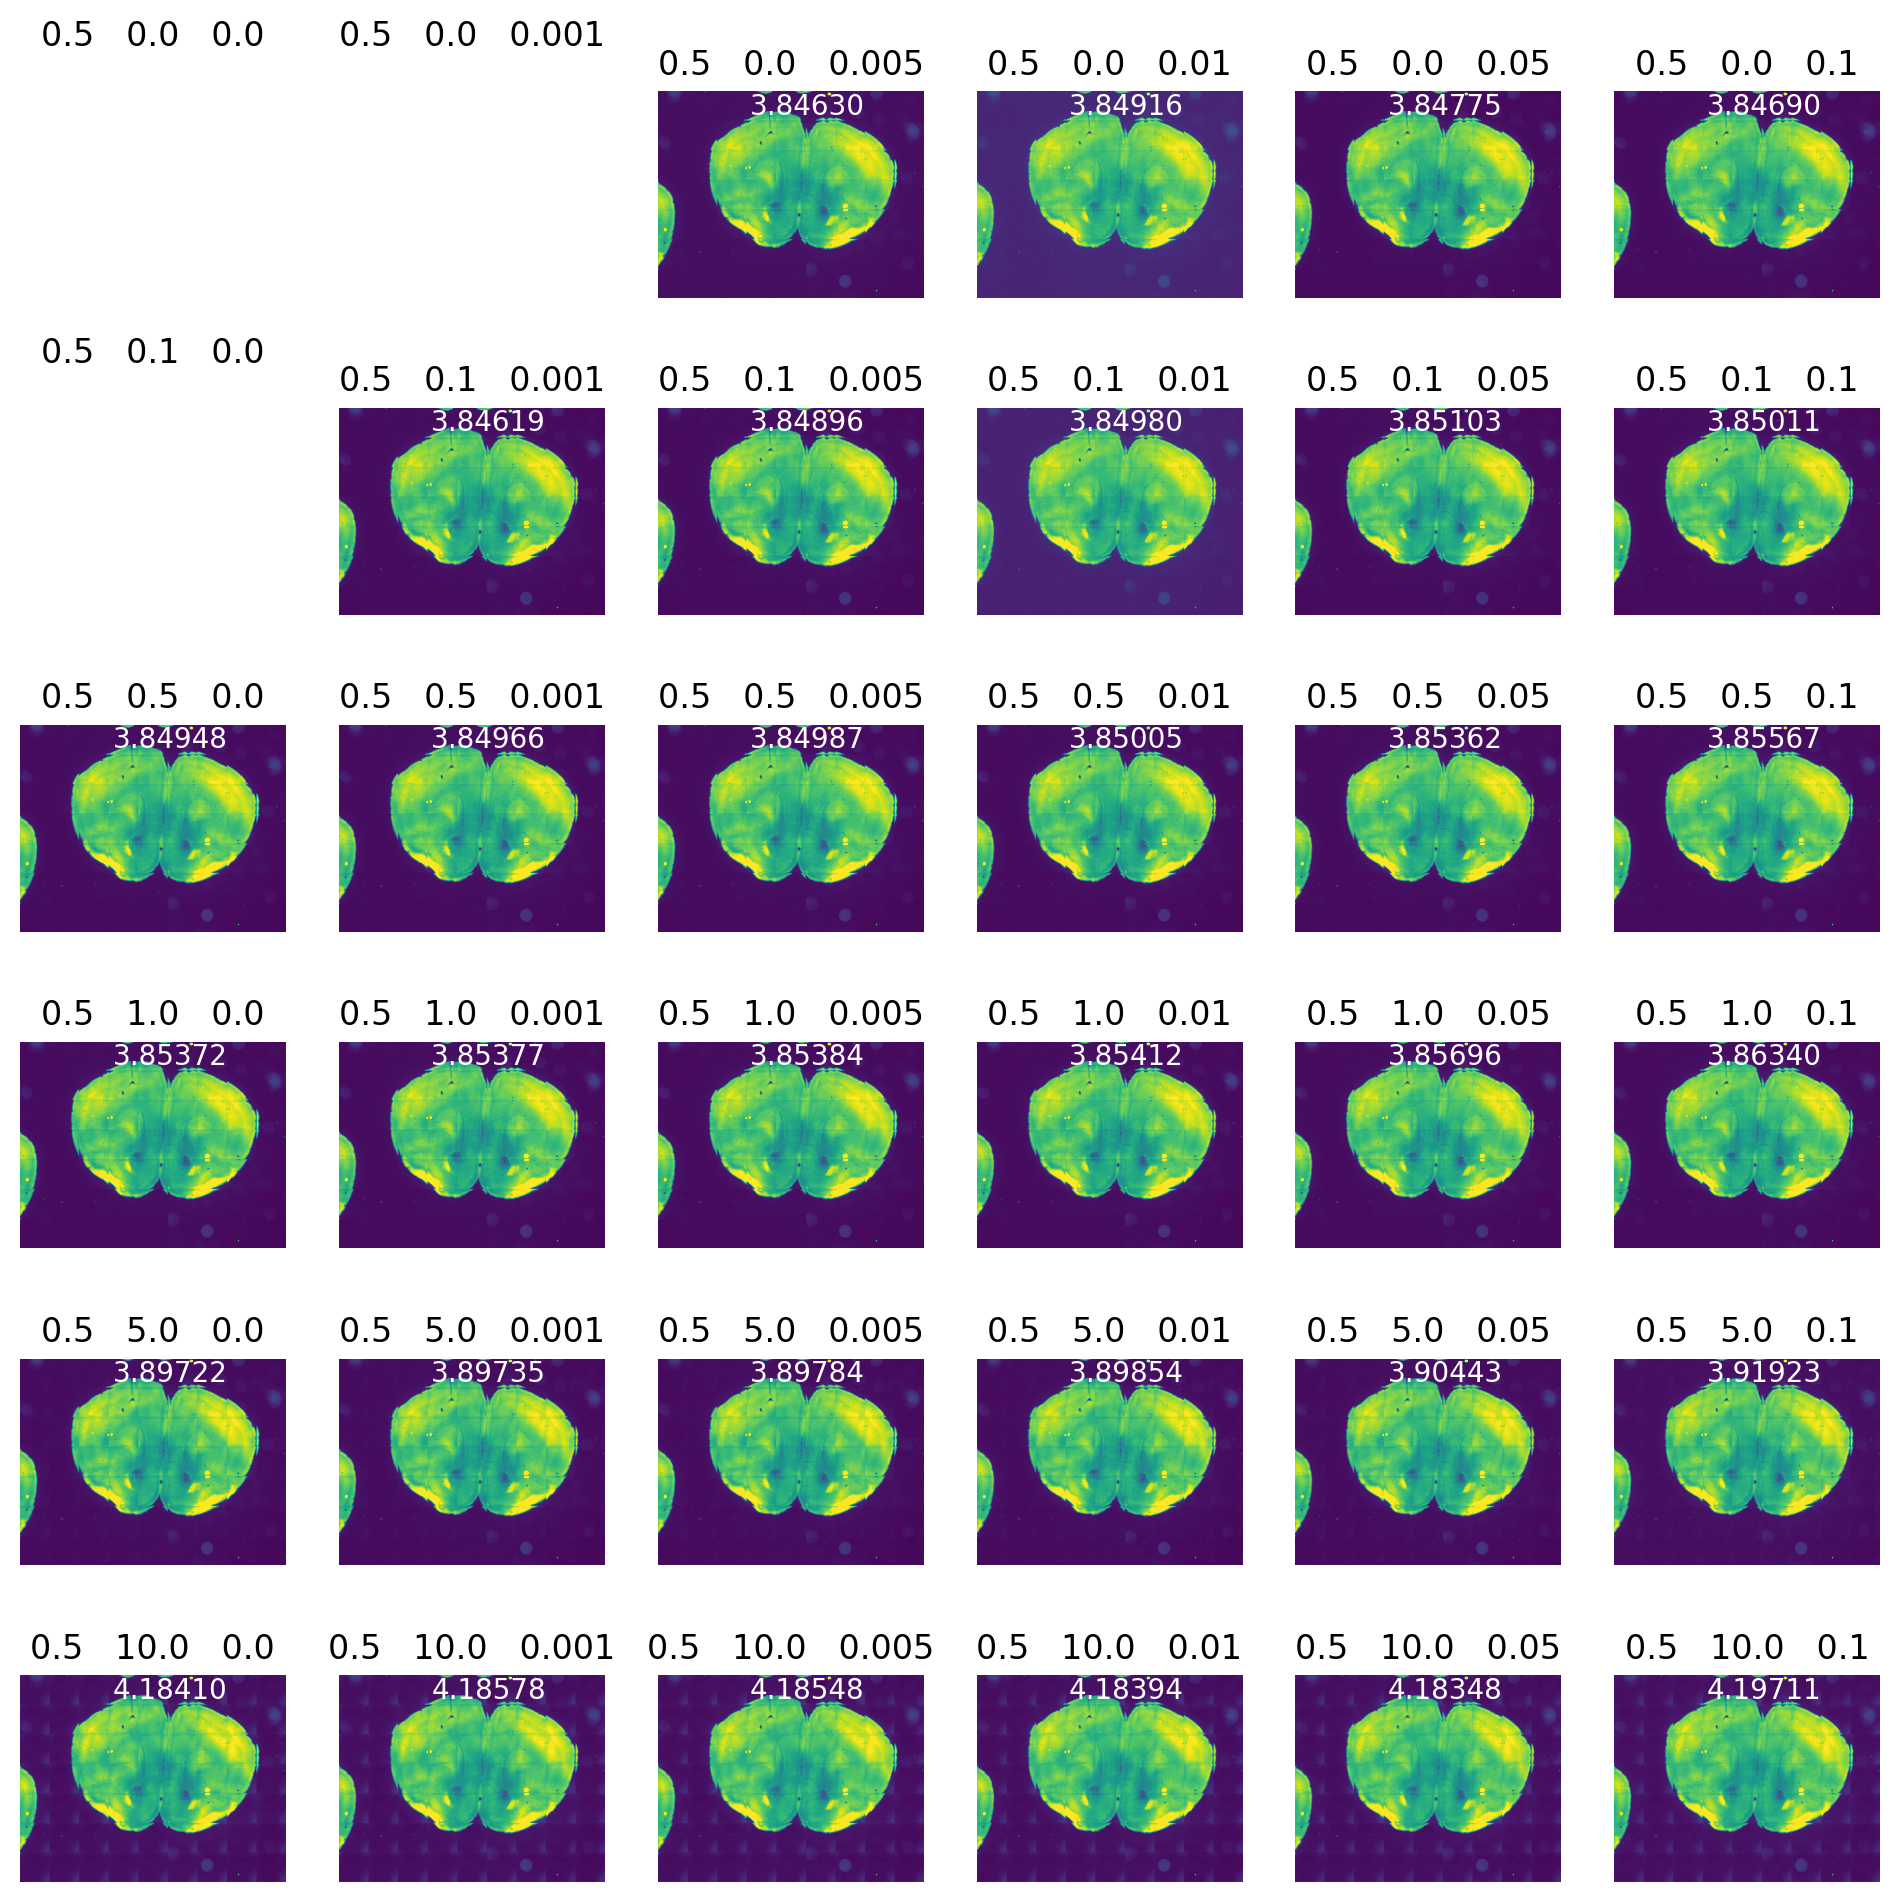

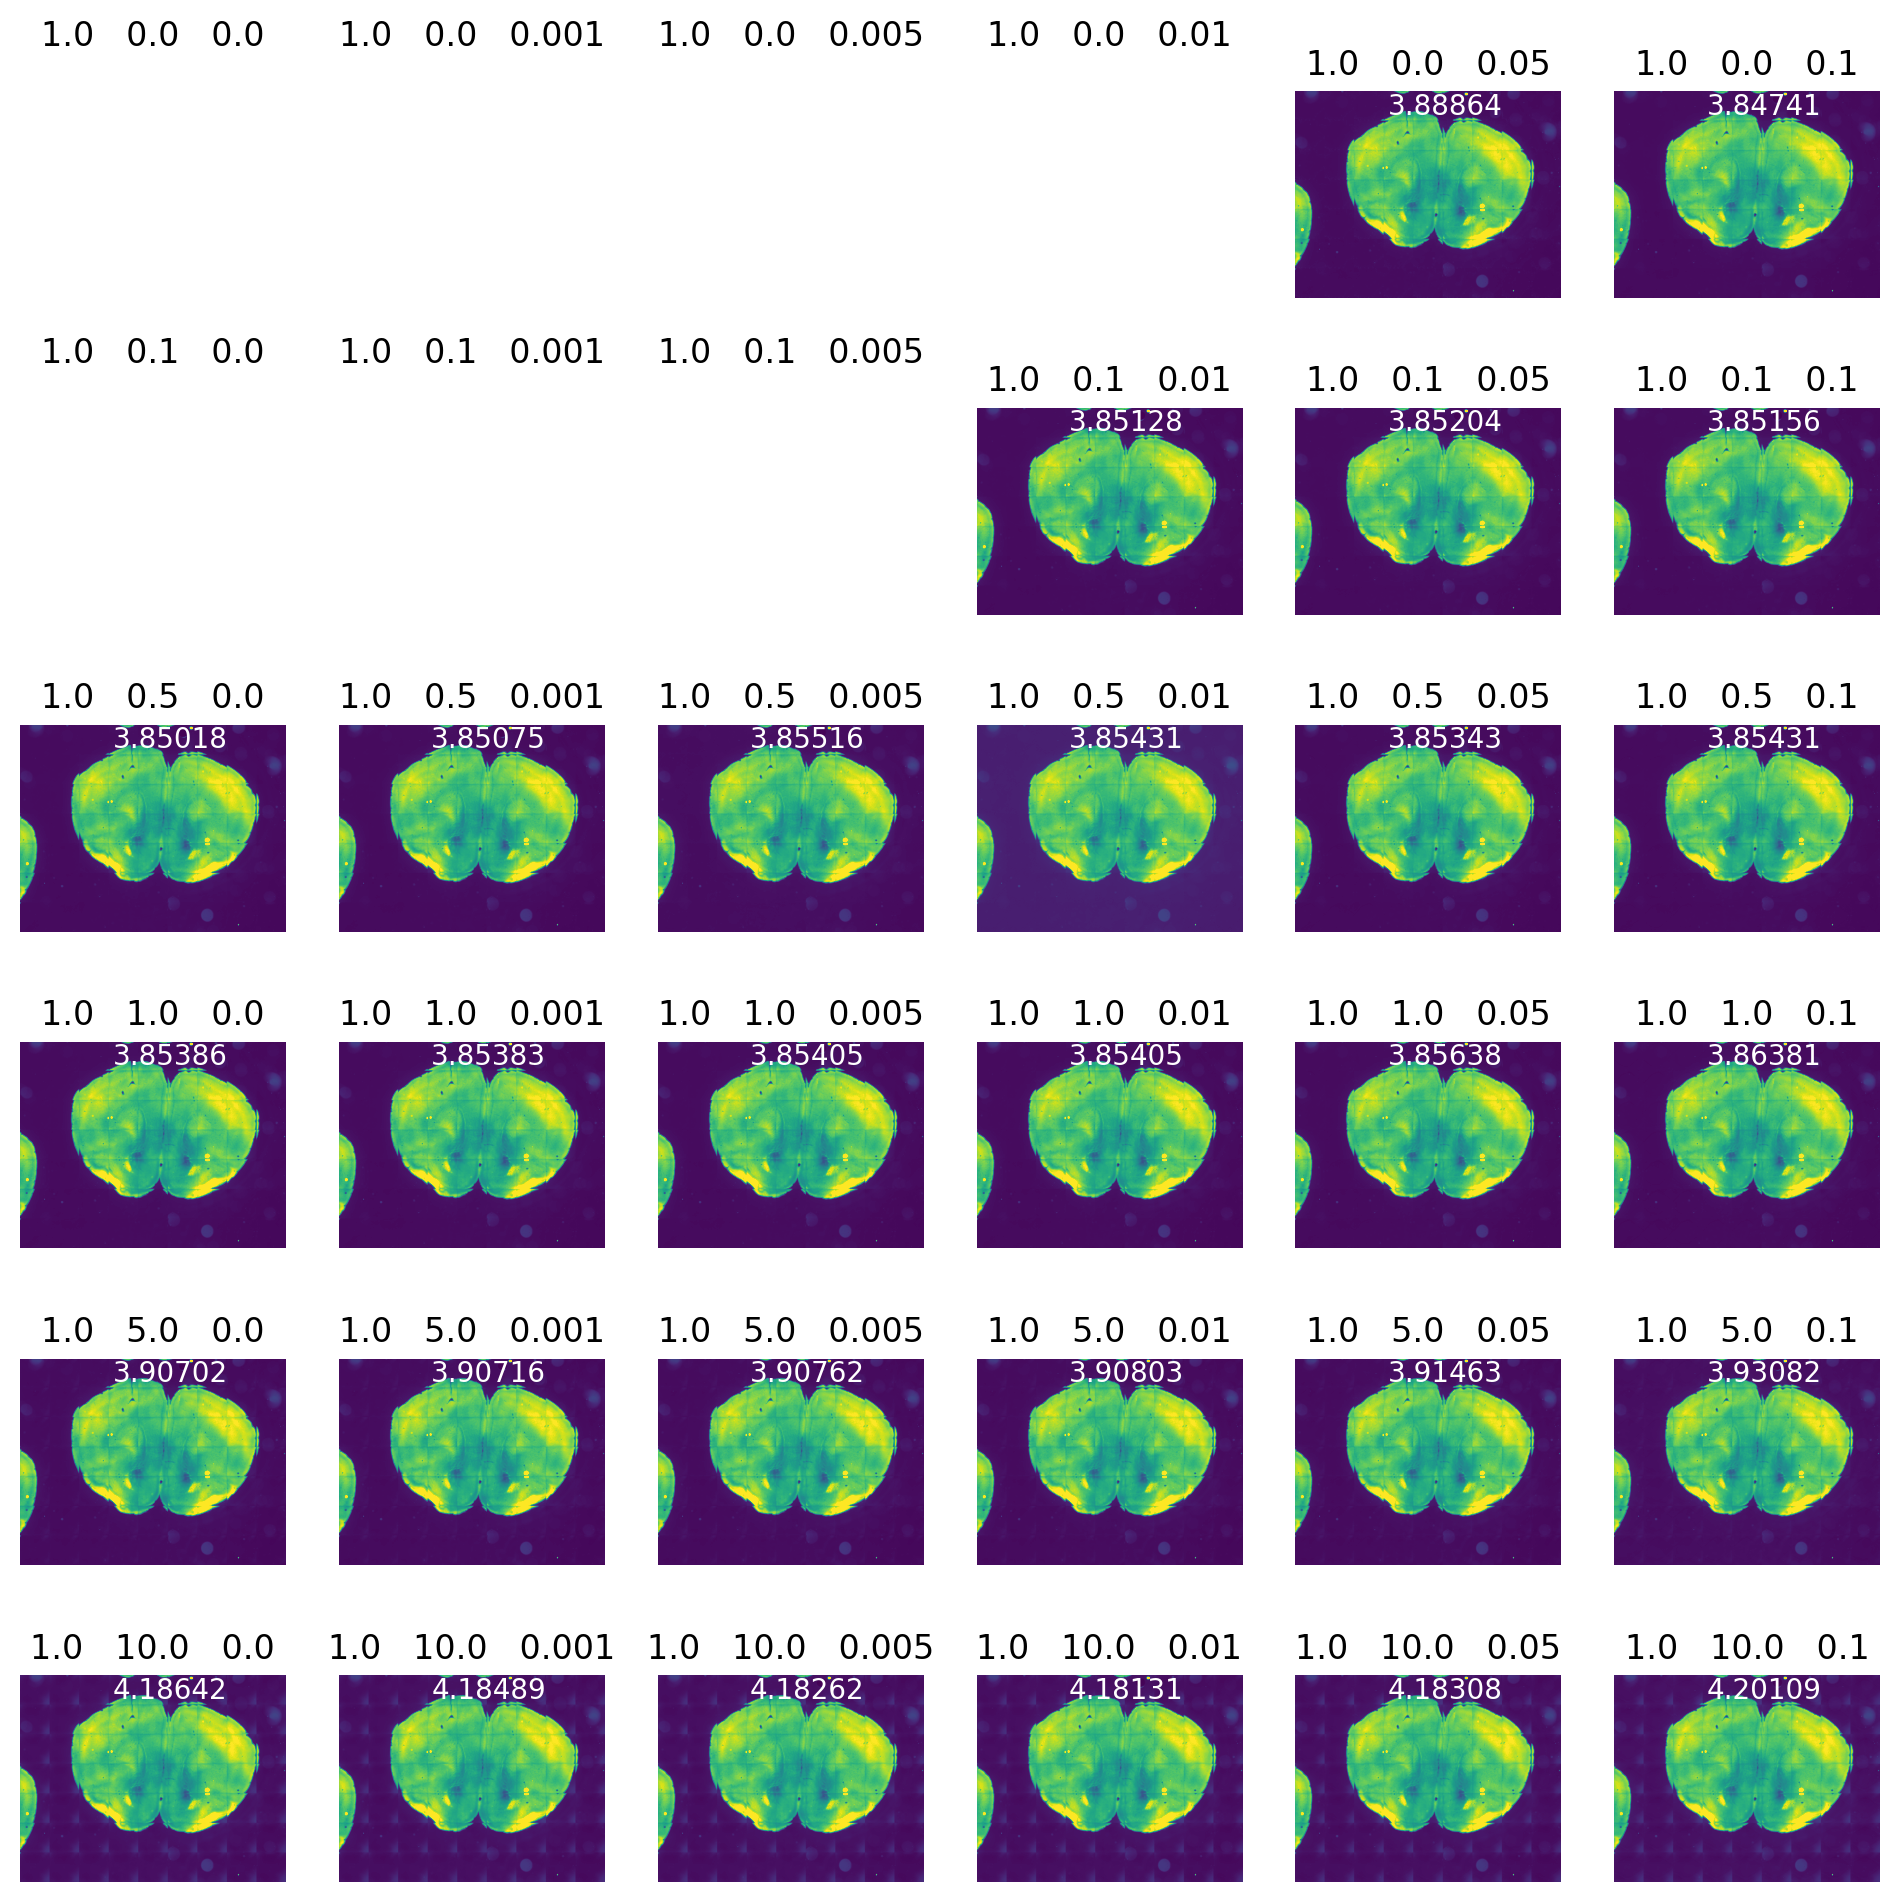

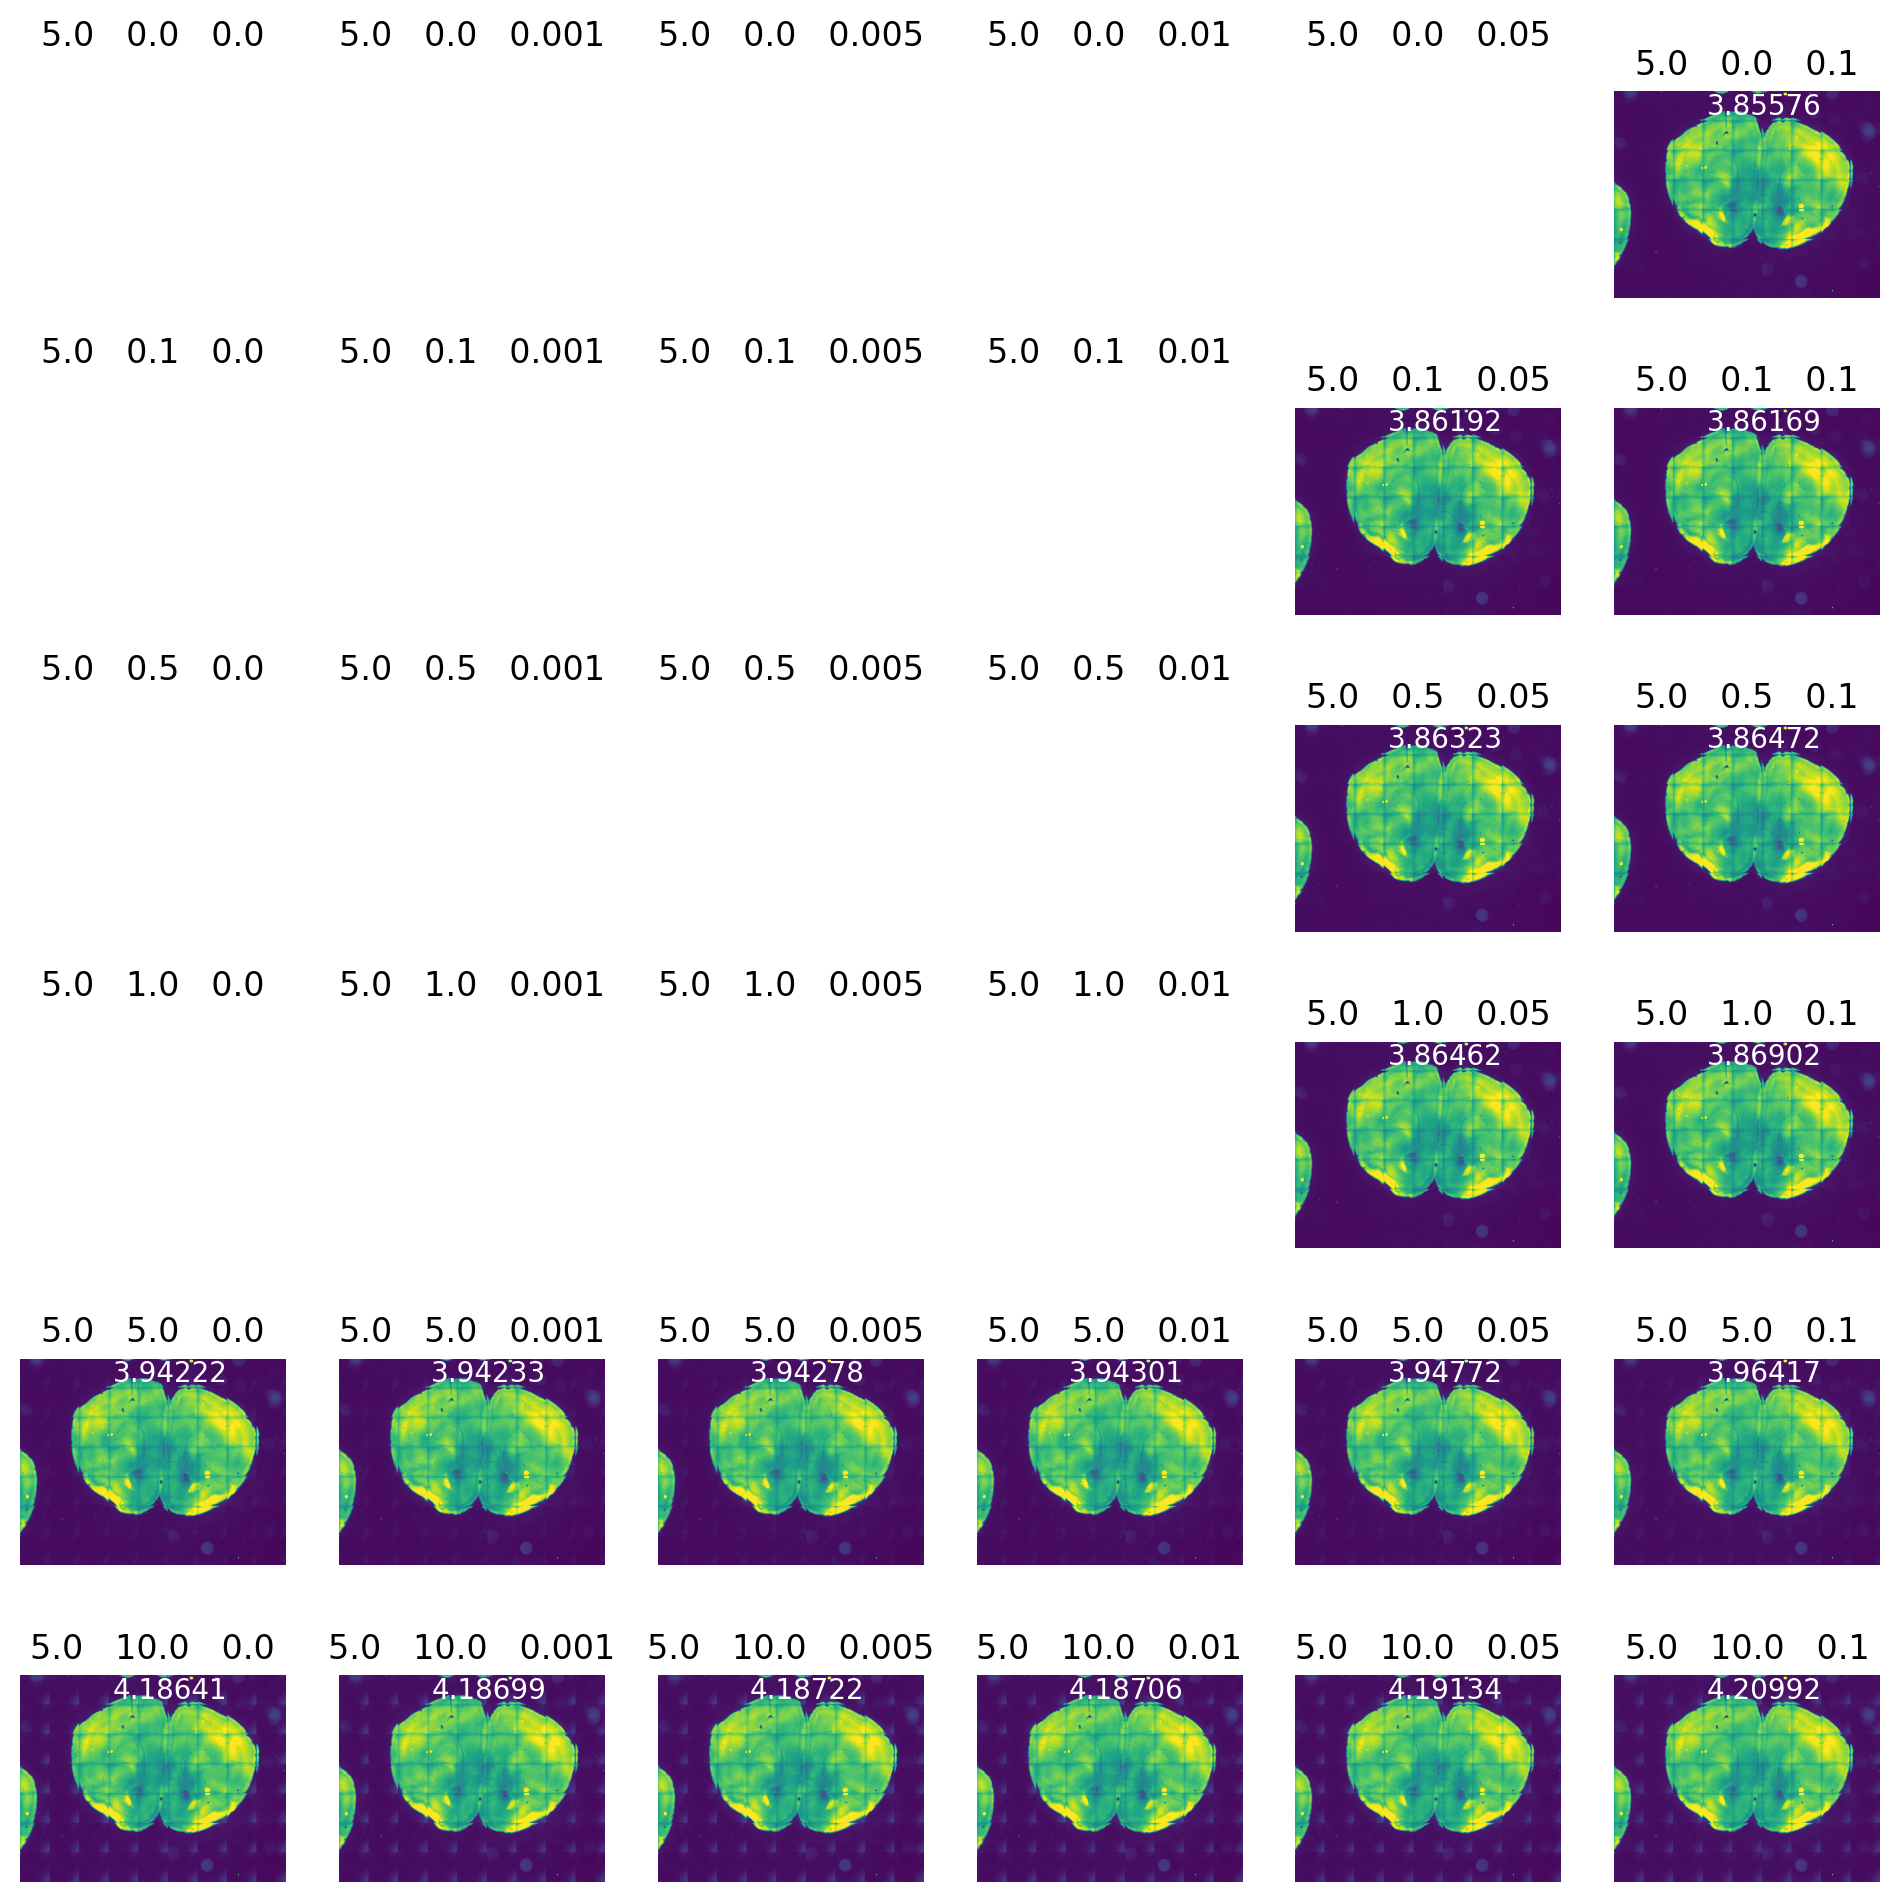

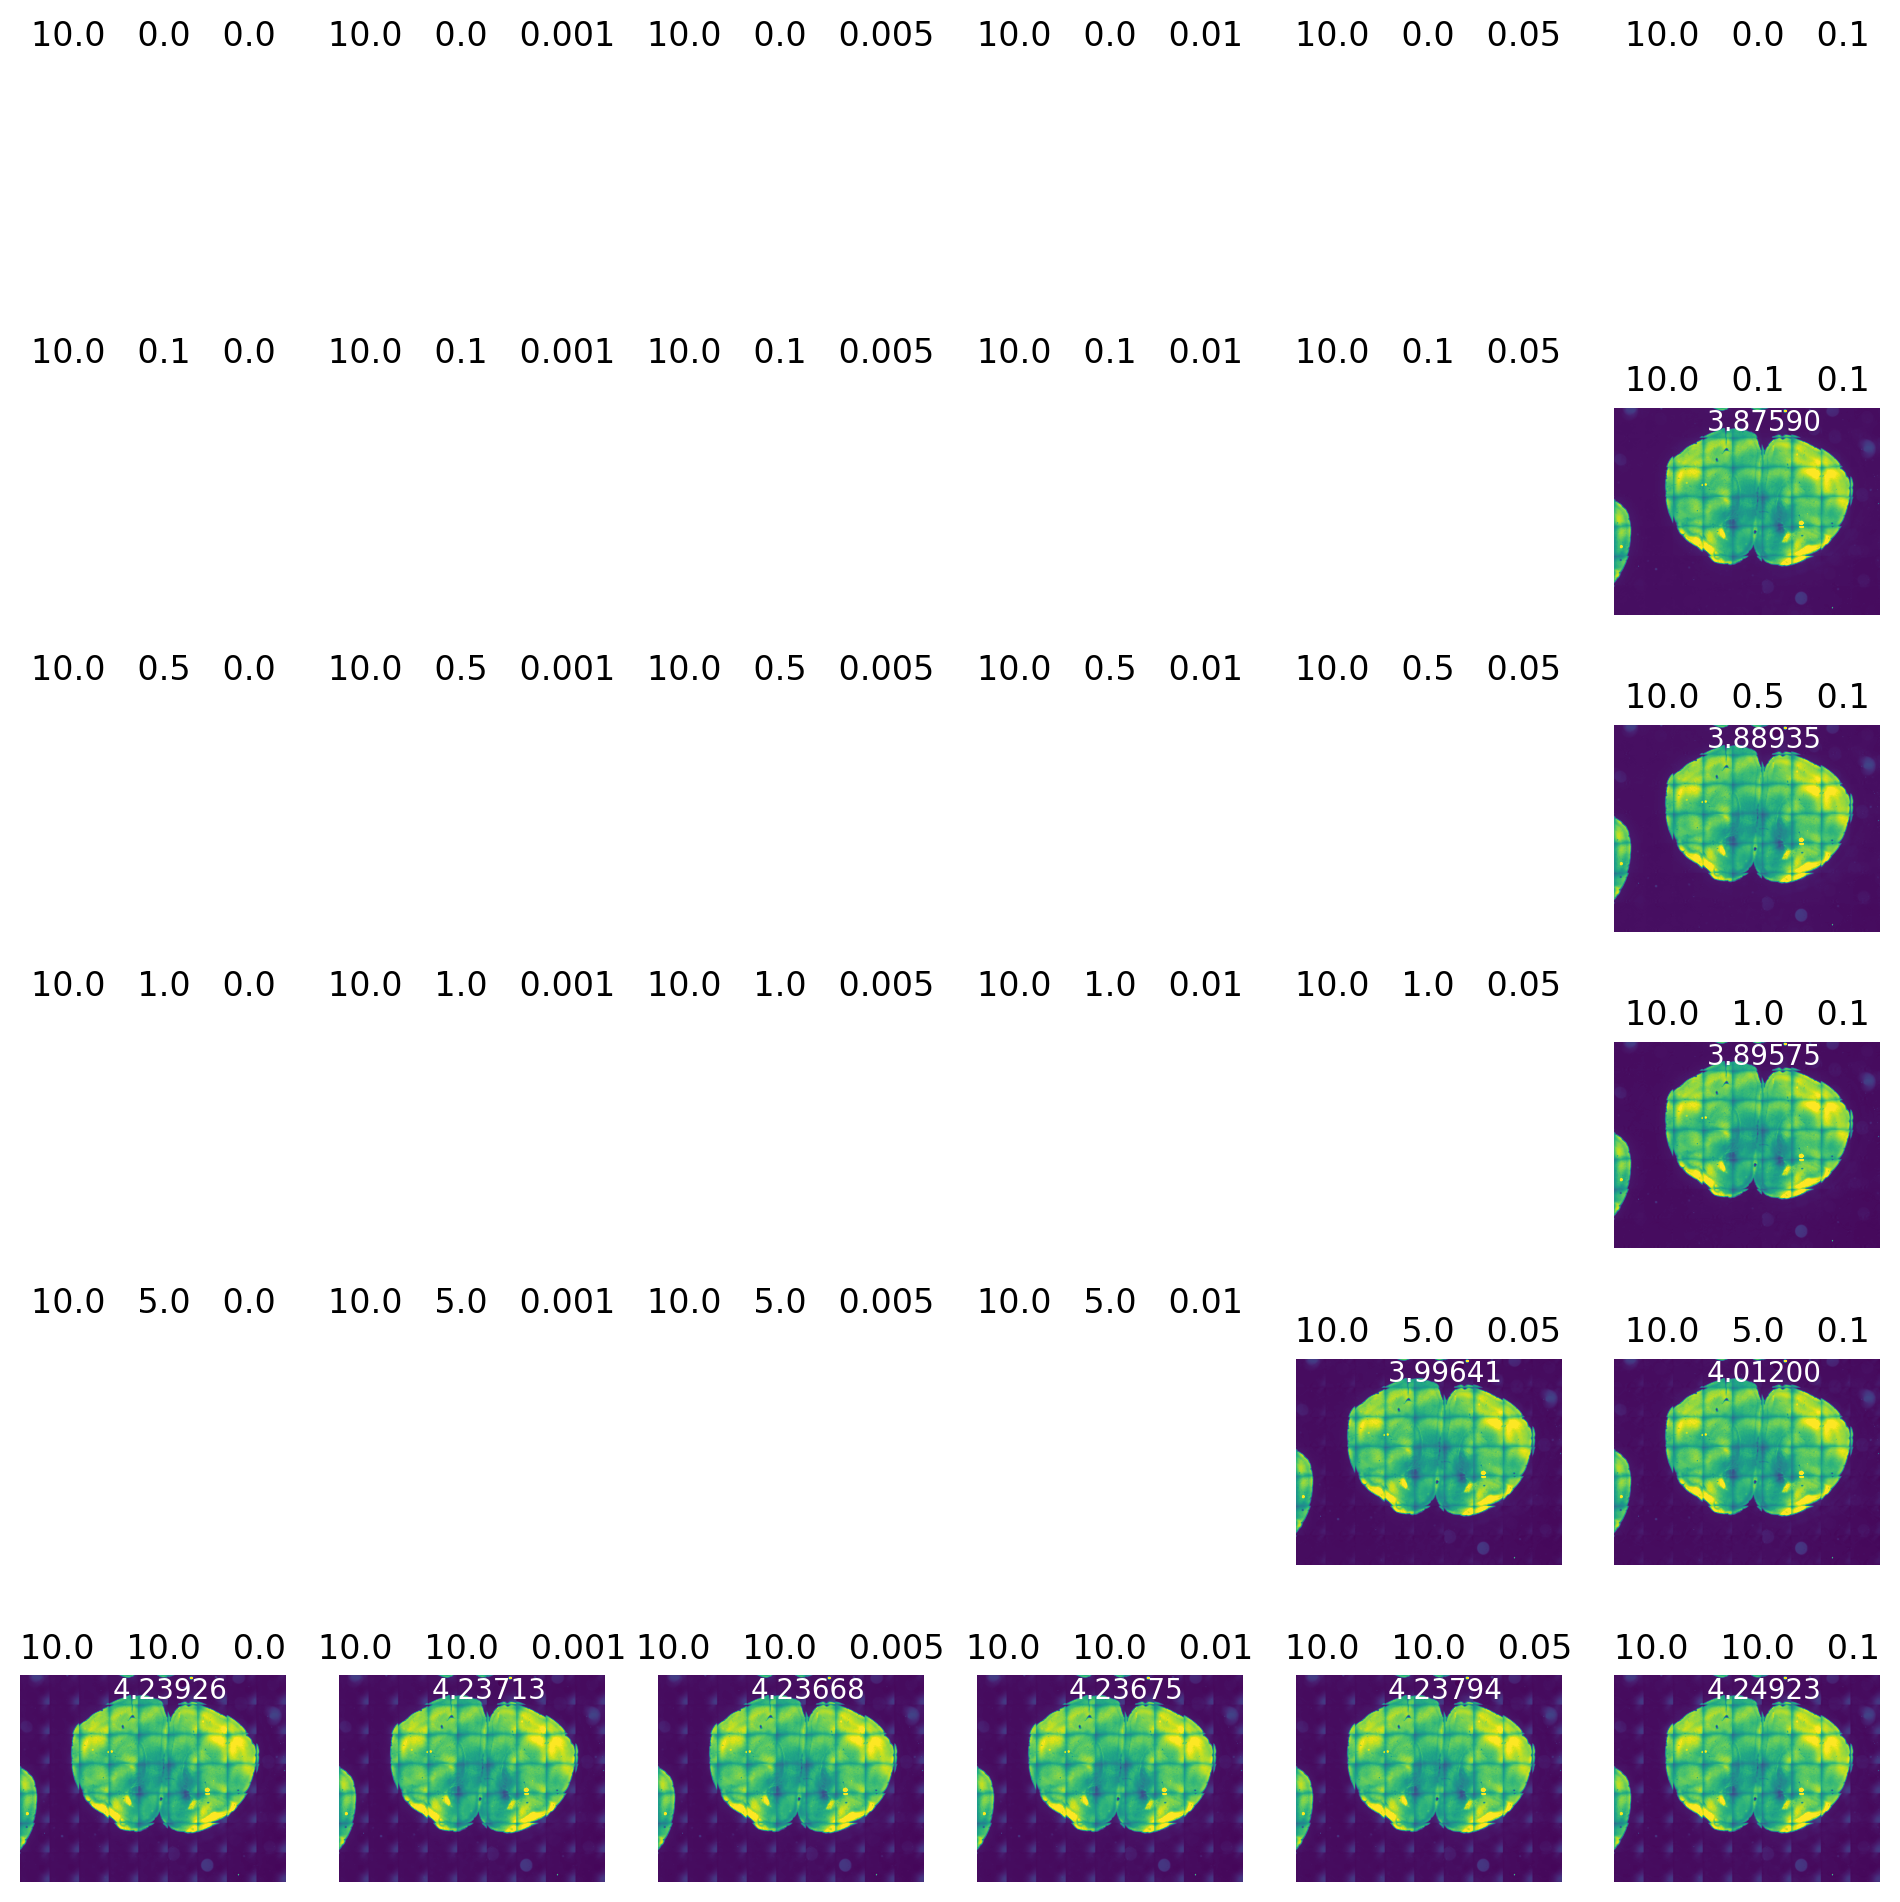

In [15]:
smoothness_flatfields = conditions_df["smoothness_darkfield"].unique()
smoothness_darkfields = conditions_df["smoothness_darkfield"].unique()
sparse_cost_darkfields = conditions_df["sparse_cost_darkfield"].unique()

for smoothness_flatfield in smoothness_flatfields:
    fig, axes = plt.subplots(
        len(smoothness_darkfields), len(sparse_cost_darkfields), figsize=(12, 12)
    )
    for i, smoothness_darkfield in enumerate(smoothness_darkfields):
        for j, sparse_cost_darkfield in enumerate(sparse_cost_darkfields):
            ax = axes[i][j]
            ax.set_title(
                f"{smoothness_flatfield}   {smoothness_darkfield}   {sparse_cost_darkfield}"
            )
            idx = np.where(
                (conditions_df["smoothness_flatfield"] == smoothness_flatfield)
                & (conditions_df["smoothness_darkfield"] == smoothness_darkfield)
                & (conditions_df["sparse_cost_darkfield"] == sparse_cost_darkfield)
            )
            if len(idx) > 0 and len(idx[0]) > 0:
                idx = idx[0][0]
                ax.imshow(
                    composed_images[idx], vmax=np.quantile(composed_images[idx], 0.99)
                )
                ax.text(
                    400,
                    100,
                    f"{float(conditions_df.loc[idx, 'entropy']):.5f}",
                    color="white",
                    fontsize=10,
                )
            ax.axis("off")

In [33]:
search_space = {
    "smoothness_flatfield": list(np.logspace(-3, 1, 10)),
    "smoothness_darkfield": [0] + list(np.logspace(-3, 1, 10)),
    "sparse_cost_darkfield": [0] + list(np.logspace(-3, 1, 10)),
}


def fit_and_calc_entropy(params):
    try:
        basic = BaSiC(**params, get_darkfield=True)
        basic.fit(brain_wsi_image)
        transformed = basic.transform(brain_wsi_image)
        entropy = calculate_entropy(transformed)
        return -entropy
    except RuntimeError:
        return -np.inf

In [34]:
init_params = {
    "smoothness_flatfield": 0.1,
    "smoothness_darkfield": 1e-3,
    "sparse_cost_darkfield": 1e-3,
}

In [36]:
from hyperactive import Hyperactive
from hyperactive.optimizers import HillClimbingOptimizer

optimizer = HillClimbingOptimizer(
    epsilon=0.1, distribution="laplace", n_neighbours=4, rand_rest_p=0.1
)
hyper = Hyperactive()
hyper.add_search(
    fit_and_calc_entropy,
    search_space,
    optimizer=optimizer,
    n_iter=100,
    initialize=dict(warm_start=[init_params]),
)
hyper.run()

[0] fit_and_calc_entropy (Hill Climbing): 100%|──────────| 100/100 [09:21<00:00,  5.62s/it, best_iter=0, best_pos=[2 1 1], best_score=-3.841188813688797]



Results: 'fit_and_calc_entropy'  
   Best score: -3.841188813688797  
   Best parameter set:
      'smoothness_flatfield'  : 0.007742636826811269  
      'smoothness_darkfield'  : 0.001  
      'sparse_cost_darkfield' : 0.001  
   Best iteration: 0  
 
   Random seed: 1109061608  
 
   Evaluation time   : 561.5146205425262 sec    [100.0 %]
   Optimization time : 0.020189523696899414 sec    [0.0 %]
   Iteration time    : 561.5348100662231 sec    [5.62 sec/iter]
 


In [37]:
best_params = hyper.best_para(fit_and_calc_entropy)

In [41]:
basic = BaSiC(**best_params, get_darkfield=True)
basic.fit(brain_wsi_image)
transformed = basic.transform(brain_wsi_image)
composed_image = compose_image(transformed)

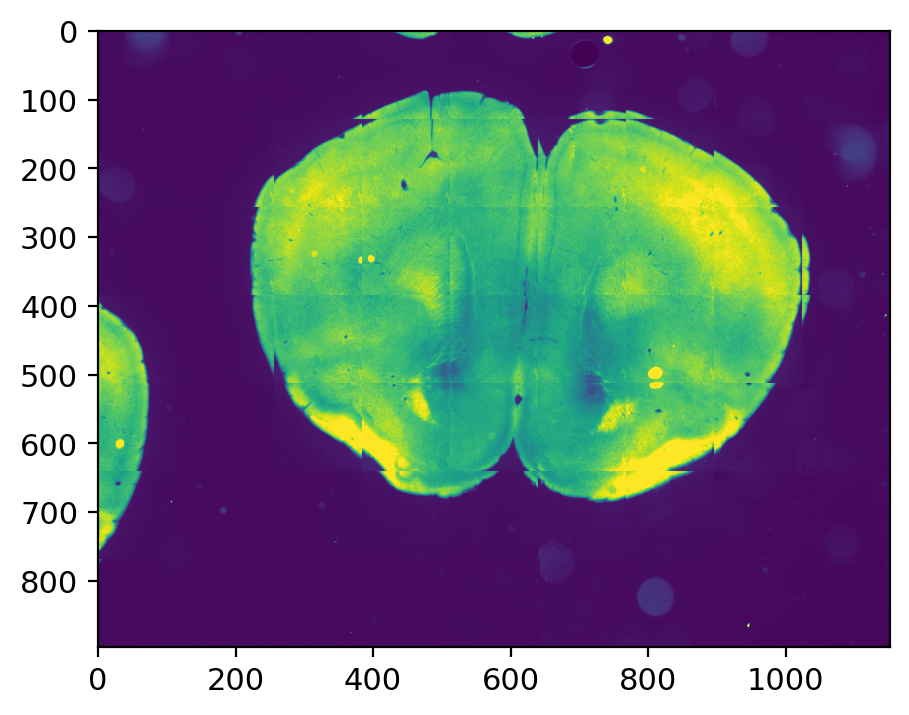

In [42]:
plt.imshow(composed_image, vmax=np.quantile(composed_image, 0.99))

In [4]:
from basicpy import BaSiC, datasets
import numpy as np

np.random.seed(42)  # answer to the meaning of life, should work here too
images = datasets.wsi_brain()

basic = BaSiC(get_darkfield=True)
basic.autotune(
    images,
    search_space={
        "smoothness_flatfield": list(np.logspace(-3, 1, 10)),
        "smoothness_darkfield": [0] + list(np.logspace(-3, 1, 10)),
        "sparse_cost_darkfield": [0] + list(np.logspace(-3, 1, 10)),
    },
    init_params={
        "smoothness_flatfield": 0.1,
        "smoothness_darkfield": 1e-3,
        "sparse_cost_darkfield": 1e-3,
    },
    n_iter=10,
)

[0] fit_and_calc_entropy (Hill Climbing): 100%|──────────| 10/10 [01:24<00:00,  8.42s/it, best_iter=0, best_pos=[3 1 3], best_score=-3.8419849233099033]



Results: 'fit_and_calc_entropy'  
   Best score: -3.8419849233099033  
   Best parameter set:
      'smoothness_flatfield'  : 0.021544346900318832  
      'smoothness_darkfield'  : 0.001  
      'sparse_cost_darkfield' : 0.007742636826811269  
   Best iteration: 0  
 
   Random seed: 1608637542  
 
   Evaluation time   : 84.17610549926758 sec    [99.99 %]
   Optimization time : 0.005155801773071289 sec    [0.01 %]
   Iteration time    : 84.18126130104065 sec    [8.42 sec/iter]
 


In [7]:
print(
    basic.smoothness_flatfield,
    basic.smoothness_darkfield,
    basic.sparse_cost_darkfield,
)

0.021544346900318832 0.001 0.007742636826811269
